In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Introduction**
  In this project, our aim is to employ various clustering algorithms to group images of individuals. Our database encompasses a variety of photos featuring 15 distinct individuals. The objective is to develop and execute a system that effectively segregates these individuals' images from one another.
![plot.png](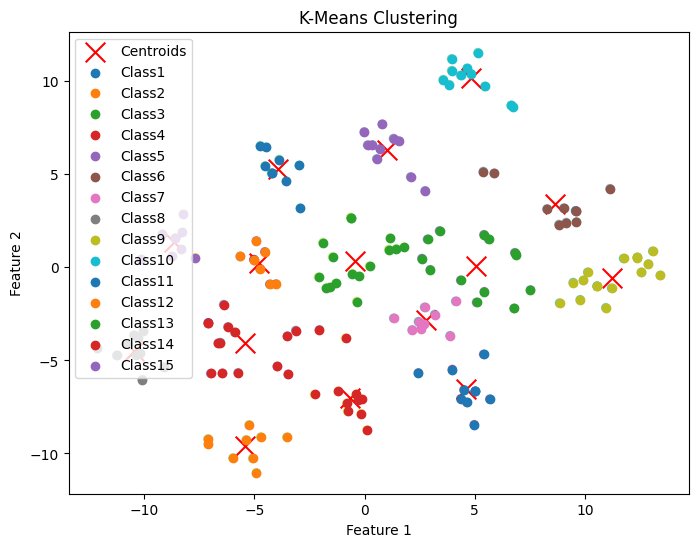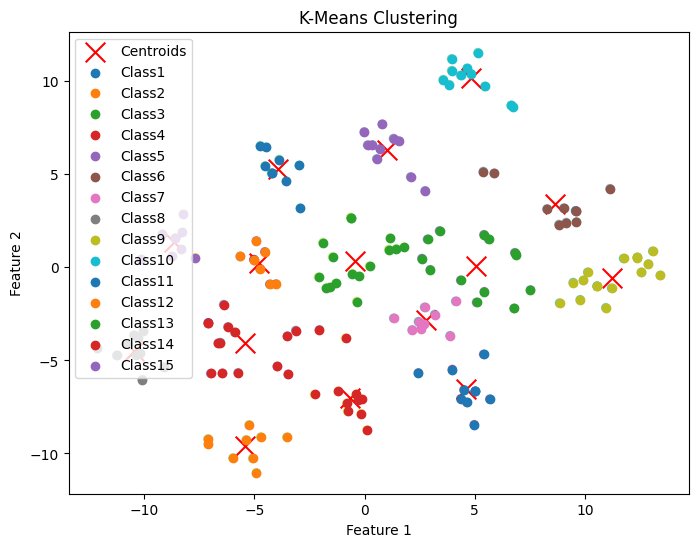)

# **Phase 1: Feature Extracting**
  In this phase, our approach began with feature extraction from the images, generating a unique feature vector for each. To achieve this, we utilized two models: VGG16 and ResNet50.

# Imports
Before we get started, we need to import the modules needed in order to load/process the images along with the modules to extract and cluster our feature vectors.

In [1]:
# for loading/processing the images
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

# models
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.resnet50 import ResNet50

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

# Loading the Data


In [75]:
path = r"/content/drive/MyDrive/Colab Notebooks/dataset"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
subjects = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.gif'):
          # adds only the image files to the subjects list
            subjects.append(file.name)

# Some Important Variables

In [250]:
usingVgg = False # if False using ResNet50
usingPca = False # if False using t-SNE
algorithm = "DBscan" # the algorithm can be "K-Means", "MeanShift", "DBscan", "AvgLink", "SingLink", "ComLink"

# The Models

## The VGG16 Model
- VGG16 is a deep convolutional neural network model used for image classification tasks. The network is composed of 16 layers of artificial neurons, which each work to process image information incrementally and improve the accuracy of its predictions.
- VGG16 is used for image recognition and classification in new images. The pre-trained version of the VGG16 network is trained on over one million images from the ImageNet visual database, and is able to classify images into 1,000 different categories with 92.7 percent top-5 test accuracy. VGG16 can be applied to determine whether an image contains certain items, animals, plants and more.

## The ResNet50 Model
- ResNet-50 is a 50-layer convolutional neural network (48 convolutional layers, one MaxPool layer, and one average pool layer). Residual neural networks are a type of artificial neural network (ANN) that forms networks by stacking residual blocks.
- The ResNet architecture follows two basic design rules. First, the number of filters in each layer is the same depending on the size of the output feature map. Second, if the feature map’s size is halved, it has double the number of filters to maintain the time complexity of each layer.


In [251]:
# load the model
if(usingVgg):
    model = VGG16()
else:
    model = ResNet50()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Data Preprocessing & Feature Extraction


In [238]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img)
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3)
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [239]:
data = {}
p = r"/content/drive/MyDrive/Colab Notebooks/subject_features.pkl"

# lop through each image in the dataset
for subject in subjects:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(subject, model)
        data[subject] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)

1/1 [==============================] - 0s 192ms/step


In [240]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))

# reshape so that there are 165 samples
if(usingVgg):
  feat = feat.reshape(-1, 4096)
else:
  feat = feat.reshape(-1, 2048)

# **Phase 2: Dimensionality Reduction**

### In Machine Learning and Statistics,in order to build a good performing model we try to pass on those features in the dataset that are significant to one another. Dimensionality reduction is the process of reducing the number of random variables under consideration, by obtaining a set of principal variables.

- ### **Principal Component analysis (PCA):**
 PCA is an unsupervised linear dimensionality reduction and data visualization technique for very high dimensional data. As having high dimensional data is very hard to gain insights from adding to that, it is very computationally intensive. The main idea behind this technique is to reduce the dimensionality of data that is highly correlated by transforming the original set of vectors to a new set which is known as Principal component. PCA tries to preserve the Global Structure of data i.e when converting d-dimensional data to d’-dimensional data then it tries to map all the clusters as a whole due to which local structures might get lost. Application of this technique includes Noise filtering, feature extractions, stock market predictions, and gene data analysis.
- ### **t-distributed stochastic neighbourhood embedding (t-SNE):**
 t-SNE is also a unsupervised non-linear dimensionality reduction and data visualization technique. The math behind t-SNE is quite complex but the idea is simple. It embeds the points from a higher dimension to a lower dimension trying to preserve the neighborhood of that point. Unlike PCA it tries to preserve the Local structure of data by minimizing the Kullback–Leibler divergence (KL divergence) between the two distributions with respect to the locations of the points in the map. This technique finds application in computer security research, music analysis, cancer research, bioinformatics, and biomedical signal processing.

In [242]:
if(usingPca):
  pca = PCA(n_components=165, random_state=22)
  pca.fit(feat)
  x = pca.transform(feat)

else:
  tsne = TSNE(n_components=2, random_state=22)
  x = tsne.fit_transform(feat)

# **Phase 3: Clustering Algorithms:**

- ### **K-Means:**
 K-Means is a popular clustering algorithm that partitions data into K clusters. It works by iteratively assigning each data point to the nearest cluster centroid and then recalculating the centroids based on the mean of the points assigned to each cluster. It aims to minimize the within-cluster variance, resulting in tight clusters around centroids.
- ### **MeanShift:**
 MeanShift is a non-parametric clustering algorithm that doesn't require specifying the number of clusters beforehand. It works by iteratively shifting data points towards the mode of the underlying data distribution until convergence. The bandwidth parameter determines the size of the region for which to estimate the density around each data point.
- ### **DBSCAN (Density-Based Spatial Clustering of Applications with Noise):**
DBSCAN is a density-based clustering algorithm that identifies clusters as regions of high density separated by regions of low density. It doesn't require specifying the number of clusters in advance and is capable of identifying clusters of arbitrary shapes. It classifies points as core, border, or noise based on their density relative to the specified parameters: epsilon (eps) and minimum number of points (min_samples).
- ### **Agglomerative Clustering:**
Agglomerative clustering is a hierarchical clustering method that recursively merges the nearest pairs of clusters until only a specified number of clusters remain. The linkage parameter determines the criteria for merging clusters, with options including **"average"**, **"single"**, and **"complete"** linkage. "Average" linkage merges clusters based on the average distance between their points, "single" linkage merges based on the minimum distance, and "complete" linkage merges based on the maximum distance.

In [252]:
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering

k = 15

if algorithm == "K-Means":
  kmeans = KMeans(n_clusters=k,random_state=22)
  kmeans.fit(x)
  labels = kmeans.labels_
  centroids = kmeans.cluster_centers_

elif algorithm == "MeanShift": #works with t-SNE reduction
  meanshift = MeanShift(bandwidth=2.9)
  meanshift.fit(x)
  labels = meanshift.labels_
  centroids = meanshift.cluster_centers_

elif algorithm == "DBscan":
  if(usingVgg):
    eps = 1.65
  else:
    eps = 1.58
  min_samples = 5
  dbscan = DBSCAN(eps=eps, min_samples=min_samples)
  dbscan.fit(x)
  labels = dbscan.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)
  print('Estimated number of clusters: %d' % n_clusters_)
  print('Estimated number of noise points: %d' % n_noise_)

elif algorithm == "AvgLink":
  agg_average = AgglomerativeClustering(n_clusters=k, linkage='average')
  agg_average.fit(x)
  labels = agg_average.labels_

elif algorithm == "SingLink":
  agg_single = AgglomerativeClustering(n_clusters=k, linkage='single')
  agg_single.fit(x)
  labels = agg_single.labels_

elif algorithm == "ComLink":
  agg_complete = AgglomerativeClustering(n_clusters=k, linkage='complete')
  agg_complete.fit(x)
  labels = agg_complete.labels_

Estimated number of clusters: 15
Estimated number of noise points: 24


# Plotting:

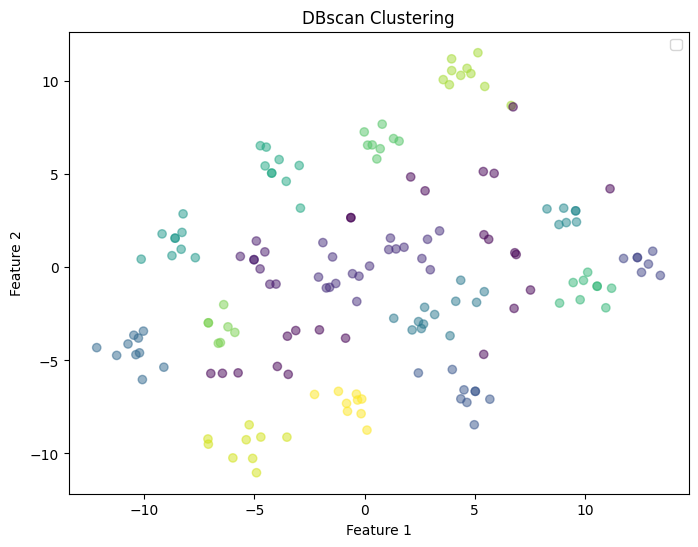

In [253]:
plt.figure(figsize=(8, 6))
plt.scatter(x[:, 0], x[:, 1], c=labels, cmap='viridis', alpha=0.5)
if(algorithm == "K-Means" or algorithm == "MeanShift"):
  plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red', s=200, label='Centroids')
  for i, c in enumerate(centroids):
      plt.scatter(x[labels == i, 0], x[labels == i, 1], label=f'Class{i+1}')
plt.title(algorithm + ' Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

# Veiwing The Clusters

In [254]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames, labels):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [255]:
import matplotlib.pyplot as plt
import numpy as np

def view_cluster(cluster):
    # Gets the list of filenames for a cluster
    files = groups[cluster]
    num_files = len(files)

    # Calculate the number of rows and columns for subplots
    num_rows = int(np.ceil(num_files / 5))  # 5 images per row
    num_cols = min(num_files, 5)

    # Create a figure with appropriate size
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

    # Set title
    fig.suptitle(f"Cluster {cluster+1} (Size: {len(files)})", fontsize=20)

    # Flatten the axes array
    axes = np.ravel(axes)

    # Plot each image in the cluster
    for i, ax in enumerate(axes):
        if i < num_files:
            img = load_img(files[i])
            img = np.array(img)
            ax.imshow(img)
            ax.axis('off')
        else:
            ax.axis('off')  # Hide empty subplots

    # Adjust layout to avoid overlap of titles
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

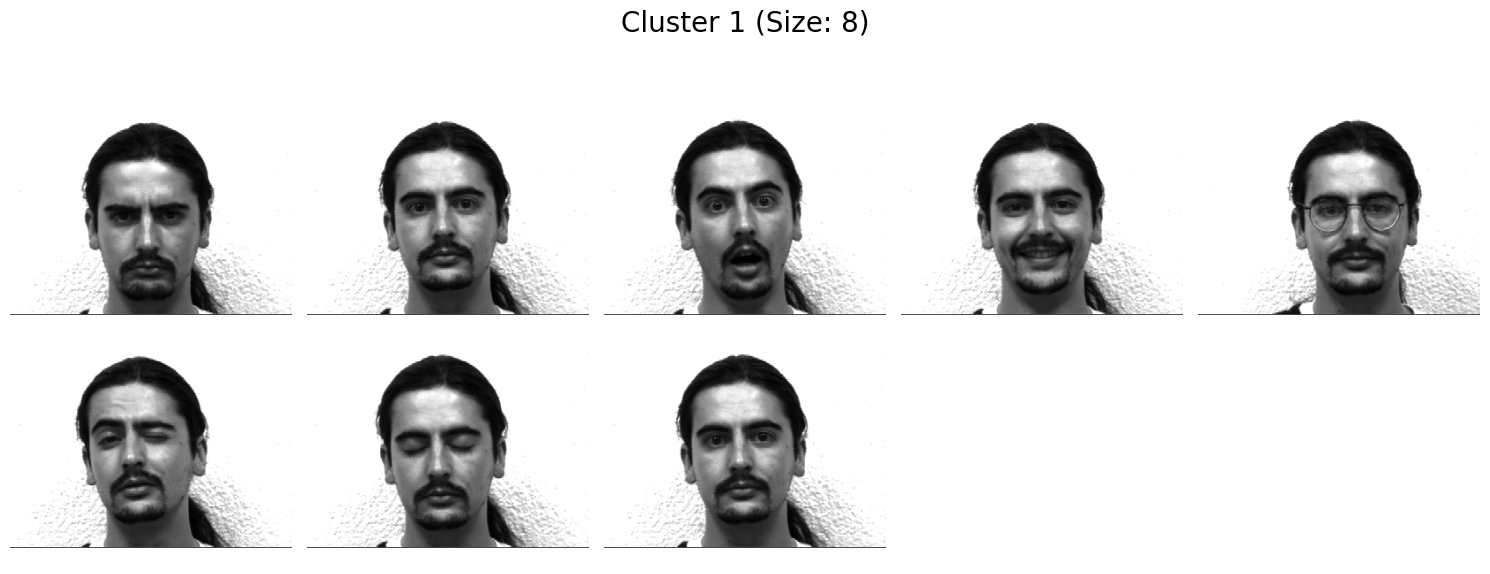

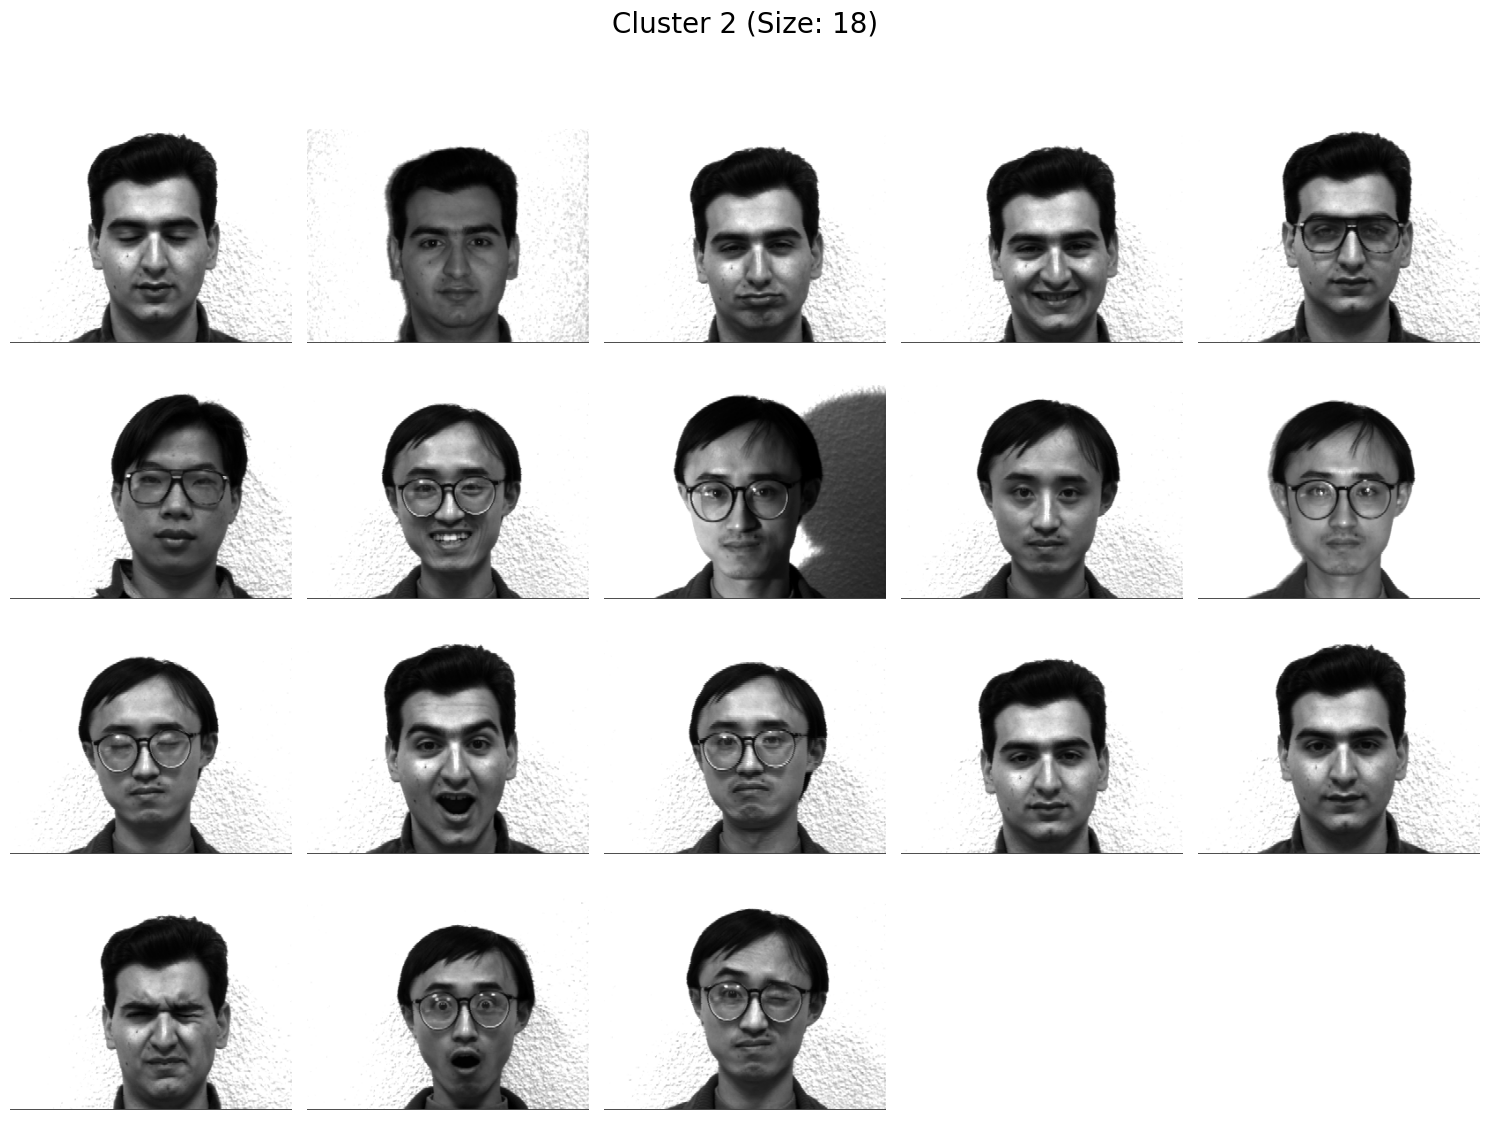

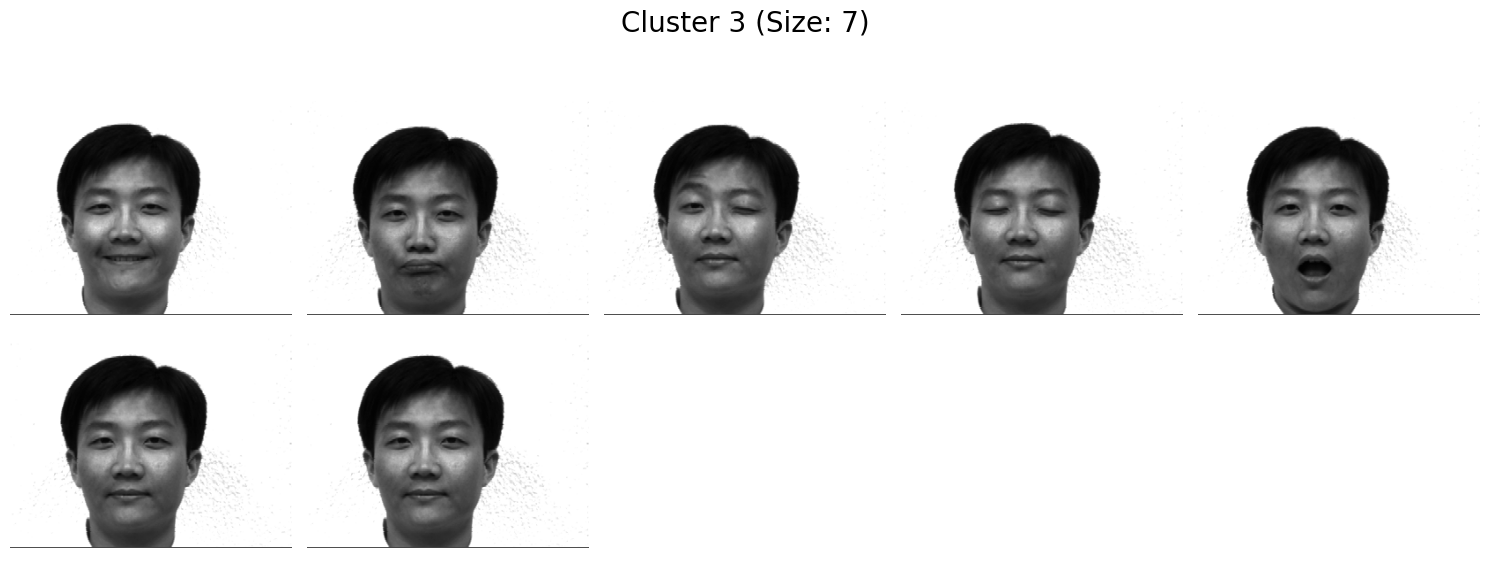

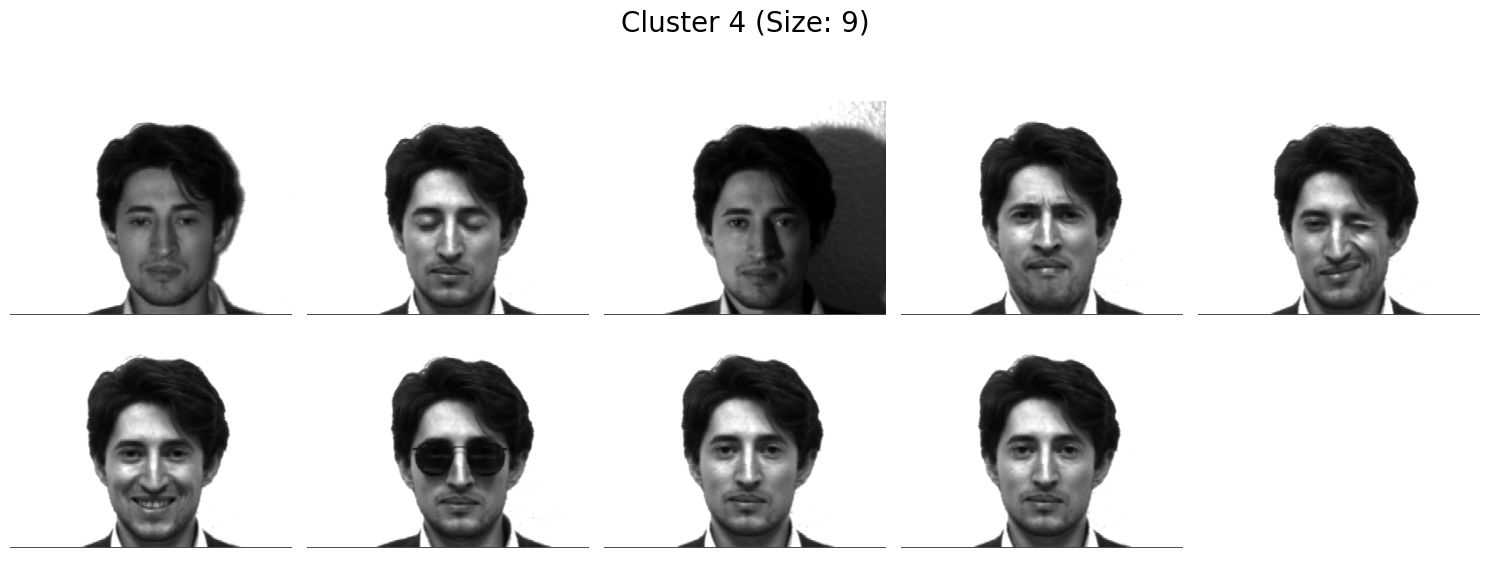

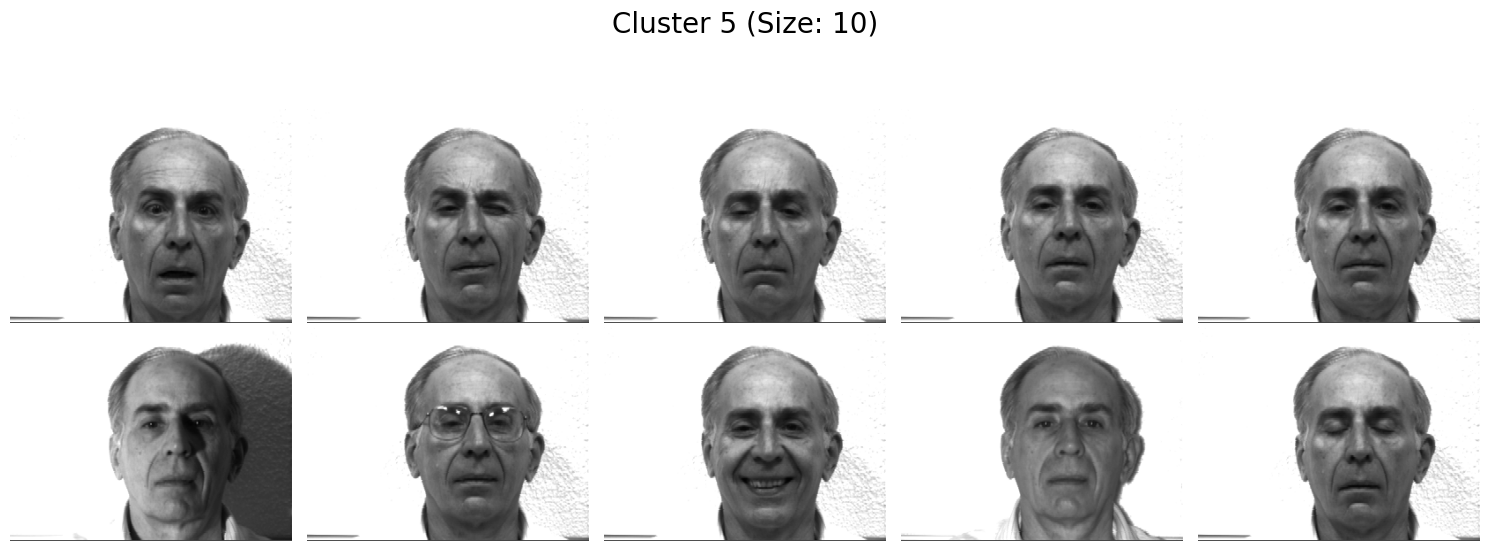

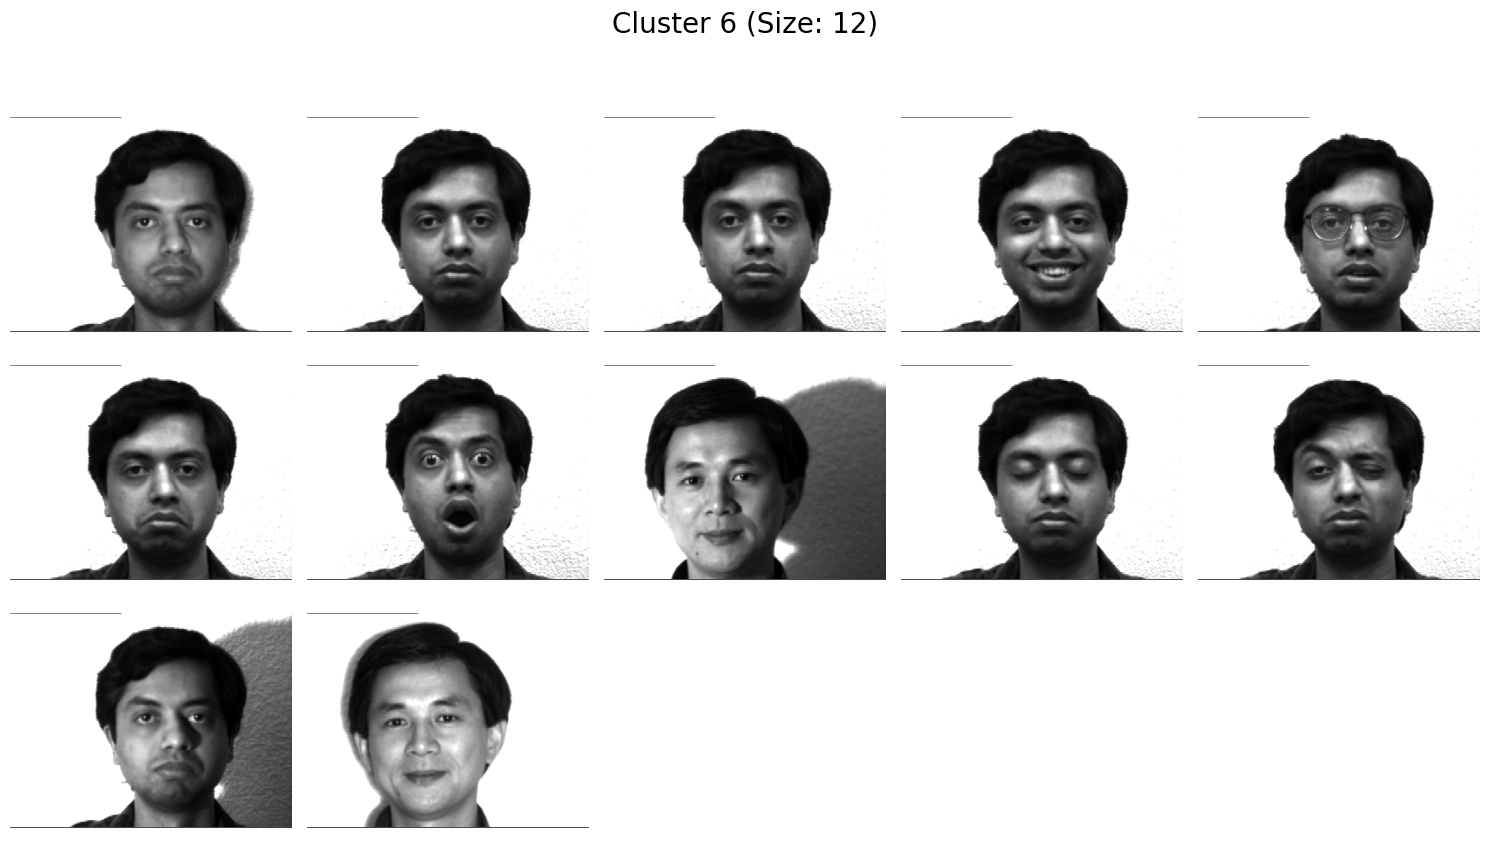

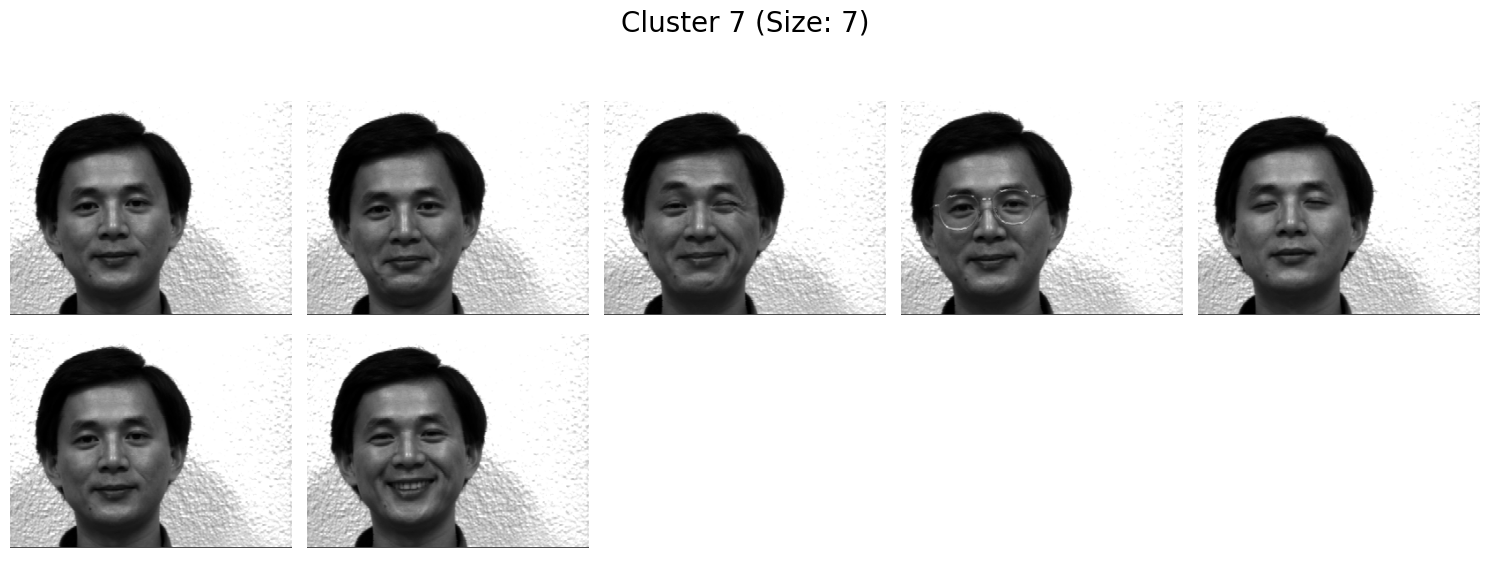

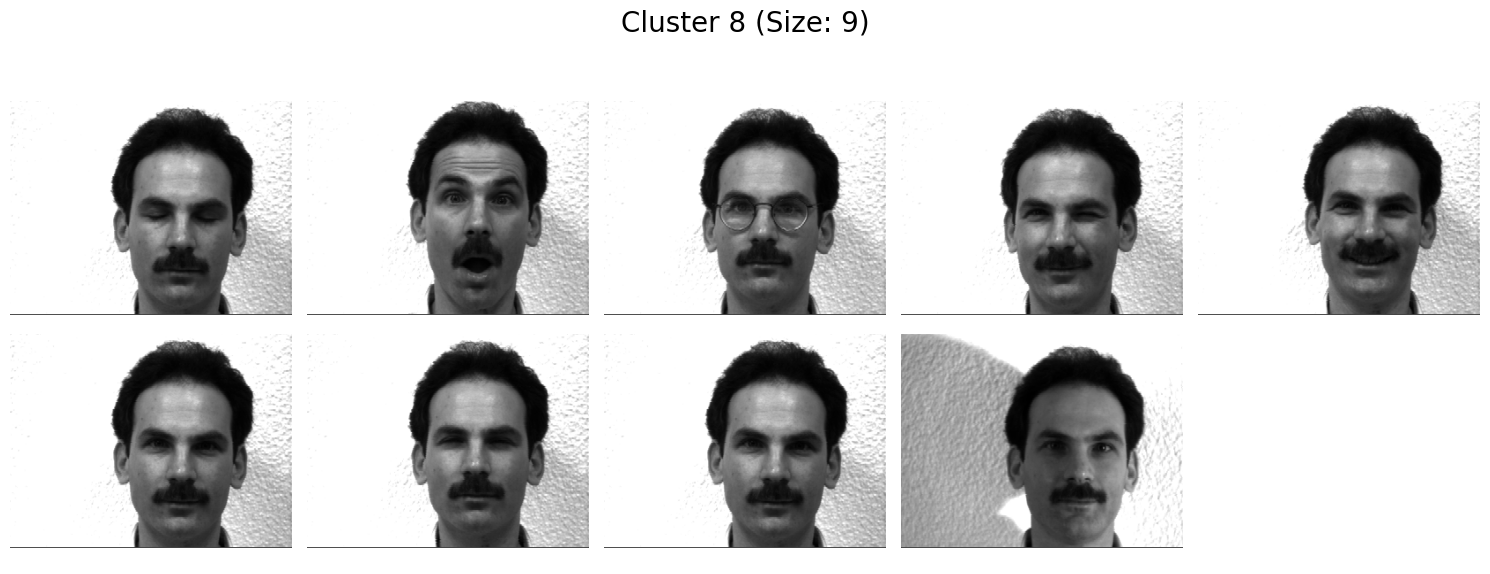

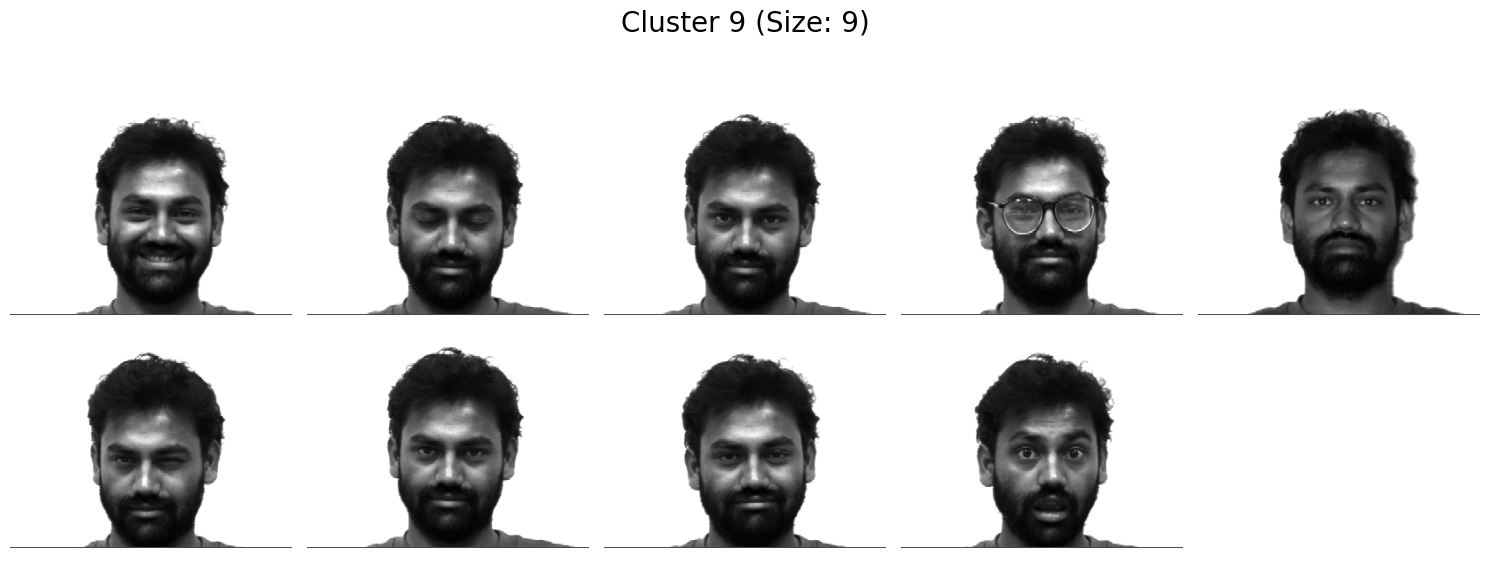

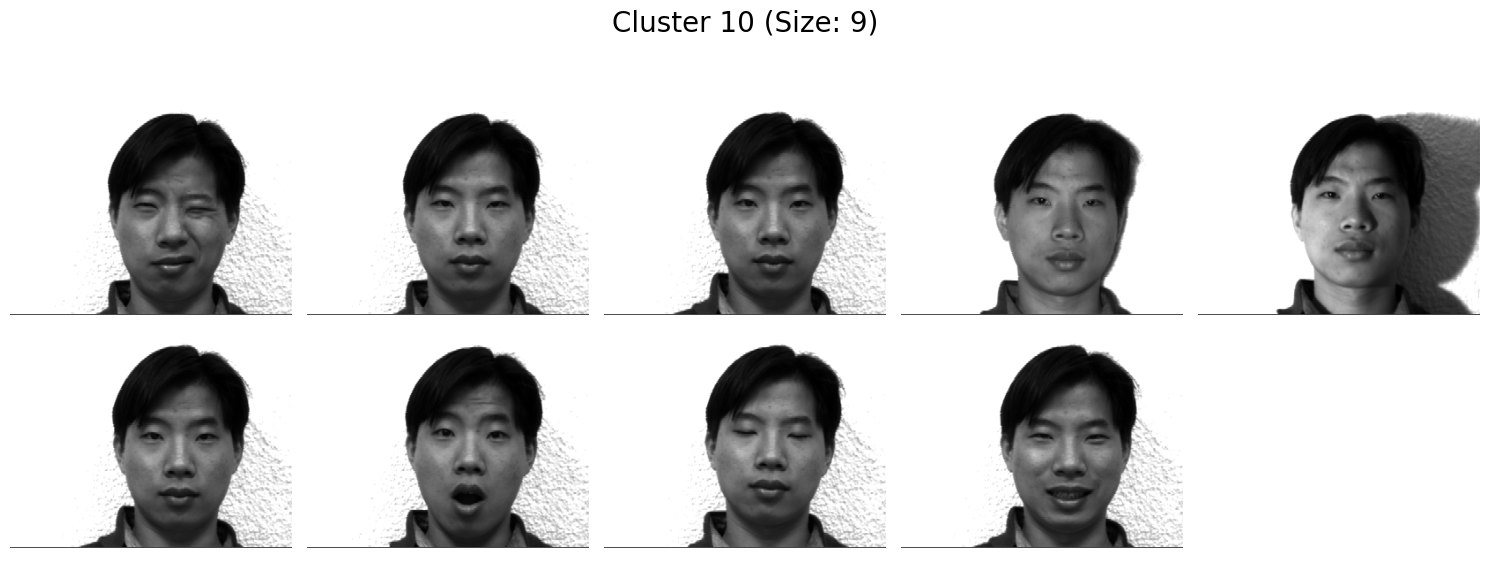

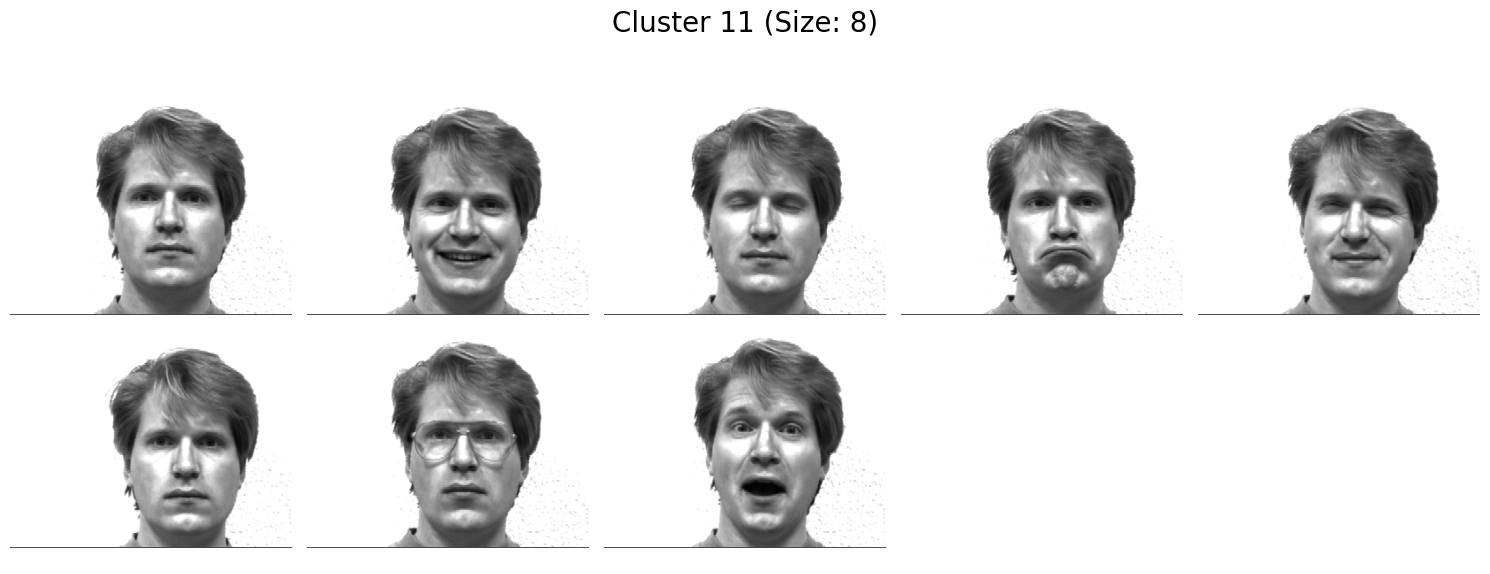

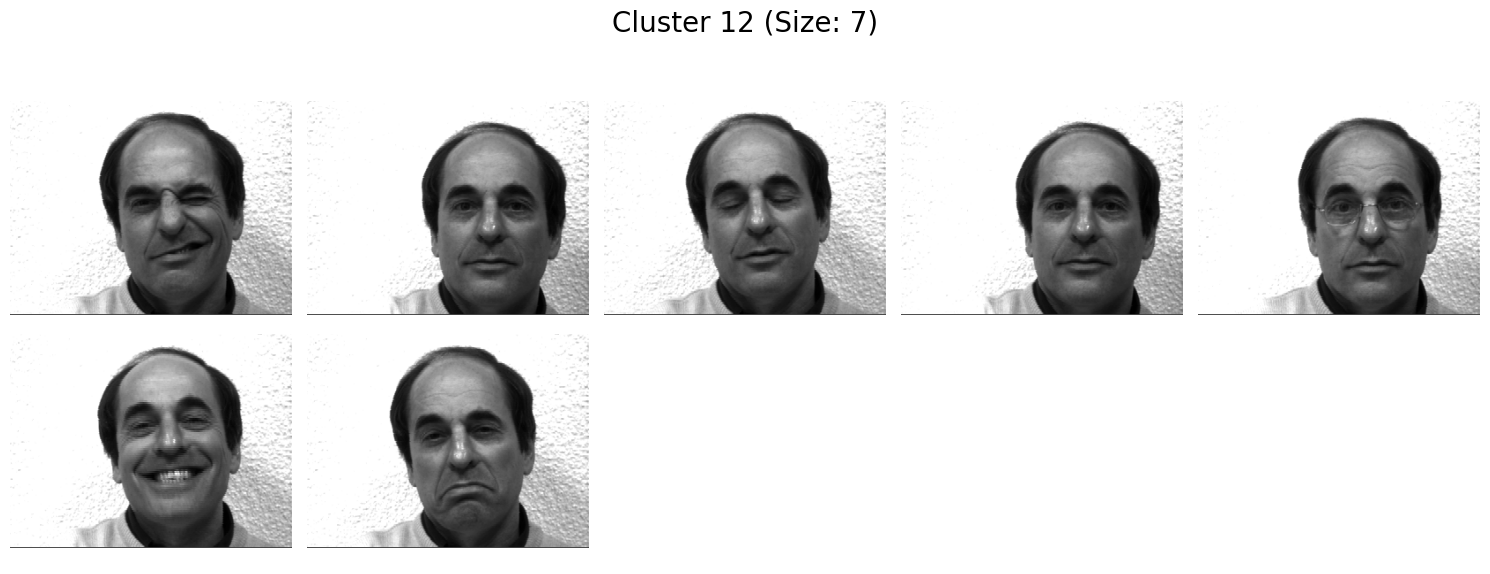

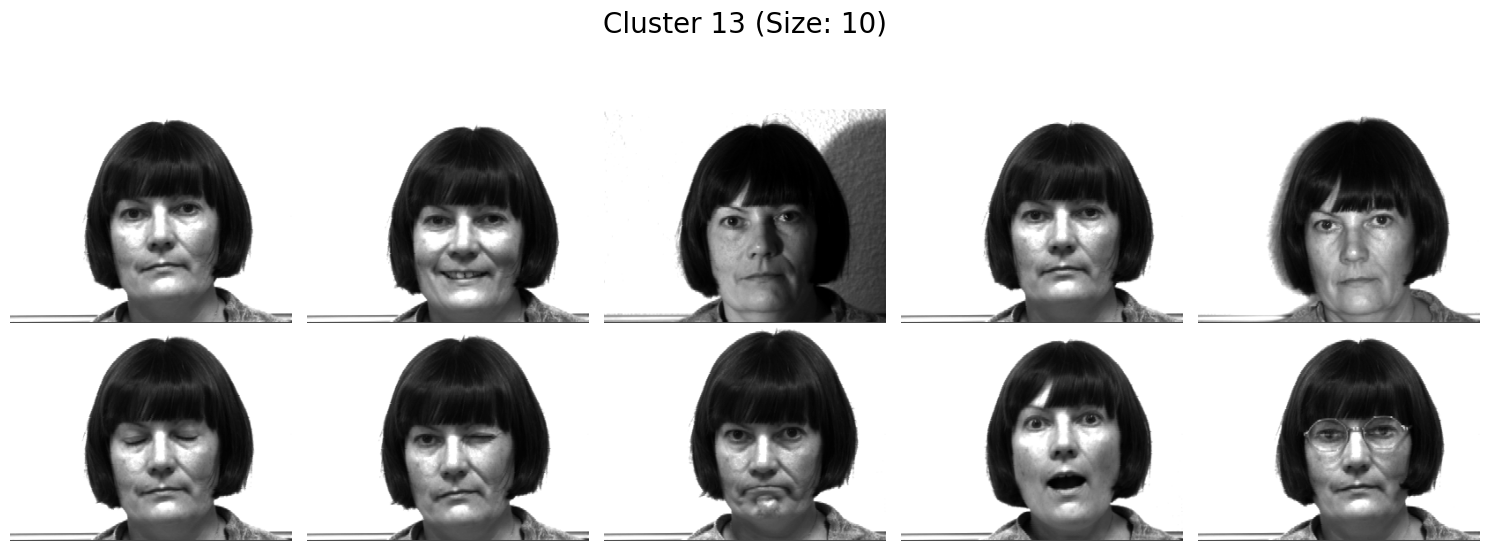

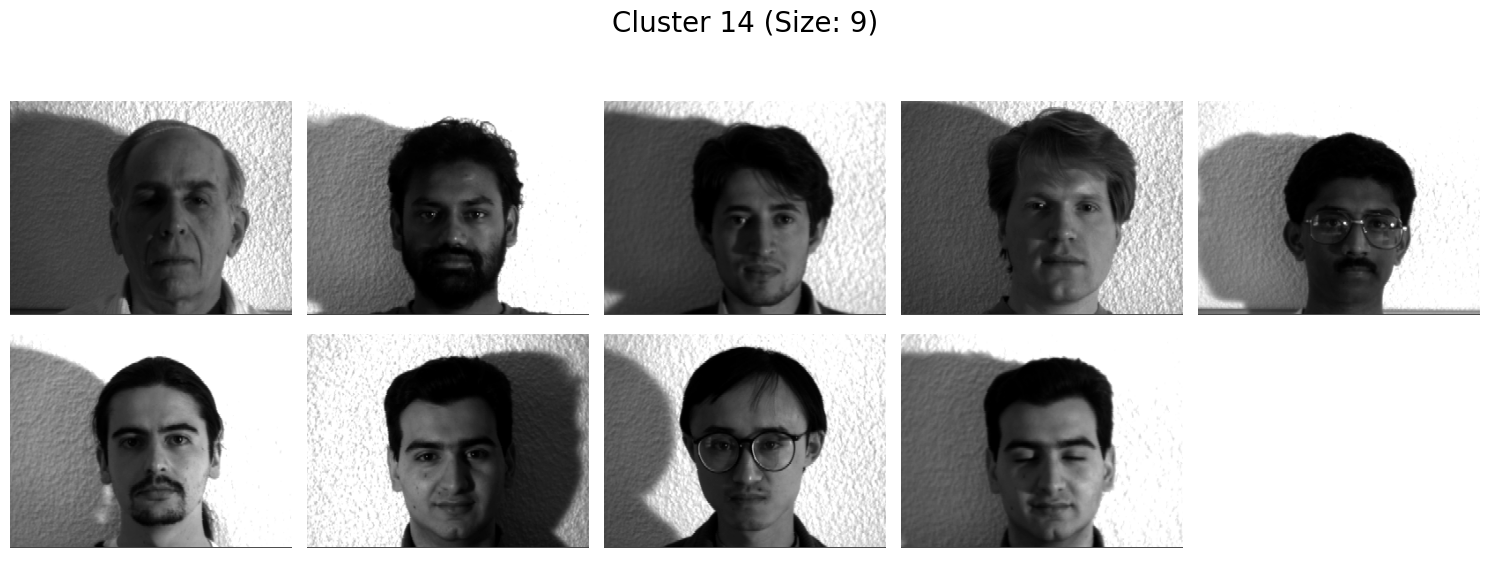

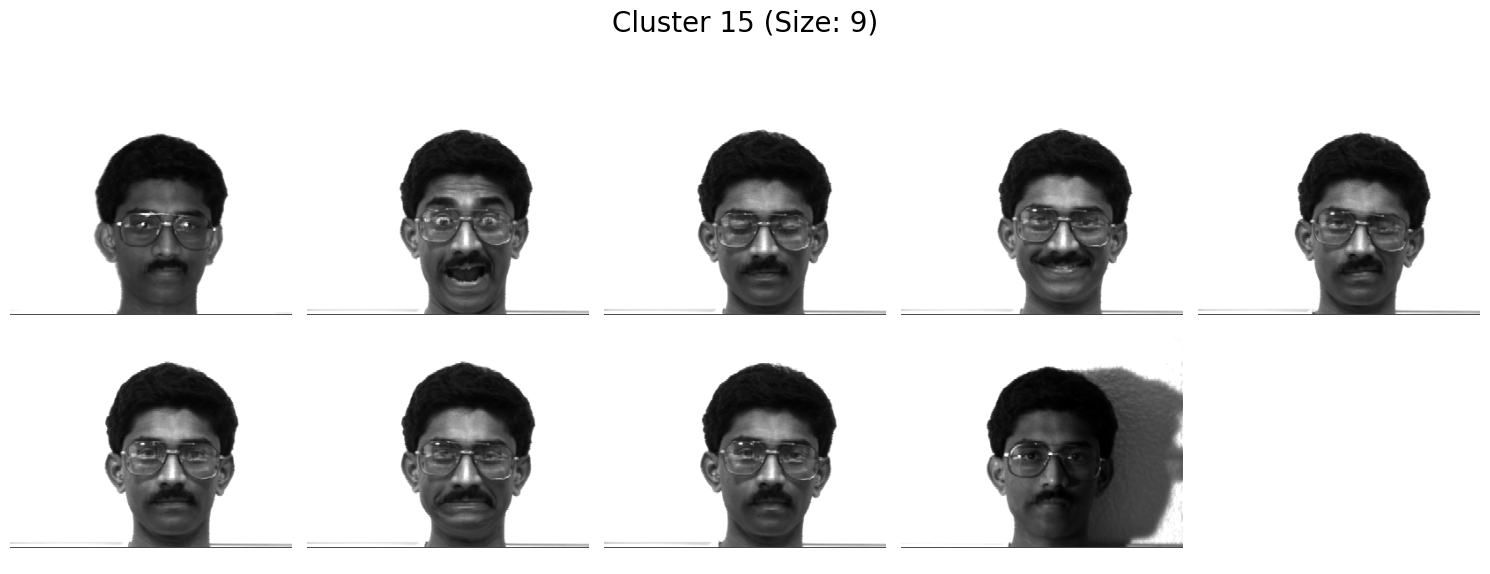

In [256]:
for i in range(15):
  view_cluster(i)

# **Phase 4.1: Report**

- ### **K-Means**
  Advantages:
  - Easy to implement and interpret
  - Fast and efficient for large datasets
  - Works well with spherical clusters

  Disadvantages:
  - Sensitive to initial centroid positions
  - Can converge to local optima
- ### **Results**
  - K-Means - VGG16:    

    Rand Index:  0.9532889874353289
  - K-Means - ResNet50:

    Rand Index:  0.9592017738359202

- ### **DBscan**
One of the advantages of DBSCAN is that it can find clusters of arbitrary shapes and sizes, unlike K-Means which assumes spherical clusters. DBSCAN is also robust to noise and outliers since they are not assigned to any cluster. However, DBSCAN can be sensitive to the choice of distance metric and parameters such as the radius and minimum number of points required to form a cluster.

- ### **Results**
  - DBscan - VGG16:
    Estimated number of clusters: 15

    Estimated number of noise points: 20

    Rand Index:  0.960727969348659

  - DBscan - ResNet50
    Estimated number of clusters: 15

    Estimated number of noise points: 24

    Rand Index:  0.9750759878419453

- ### **Comparing DBSCAN and K-Means**

DBSCAN and K-Means are among two best clustering algorithms that we used.

  - Differences between the two algorithms:

    - DBSCAN is a density-based clustering algorithm, whereas K-Means is a centroid-based clustering algorithm.
    - DBSCAN can discover clusters of arbitrary shapes, whereas K-Means assumes that the clusters are spherical.
    - DBSCAN does not require the number of clusters to be specified in advance, whereas K-Means requires the number of clusters to be specified.
    - DBSCAN is less sensitive to initialization than K-Means.

DBscan is better than K-means in clustering in this particular case because DBscan is able to handle noisy data points and outliers effectively. As seen in the results, DBscan has a lower number of noise points compared to K-means, which means DBscan is more robust in dealing with outliers. Additionally, DBscan does not require specifying the number of clusters beforehand, unlike K-means which requires the number of clusters to be set manually. This flexibility allows DBscan to adapt better to the data and find more accurate clusters, resulting in a higher Rand Index score.


- ### **Other Clustering Algorithms**



# **Phase 4.2: Rand Index**
The Rand Index is a measure of similarity between two data clusterings, where TP (true positives) is the number of pairs of elements that are in the same cluster in both the true and predicted clusterings, TN (true negatives) is the number of pairs of elements that are in different clusters in both clusterings, FP (false positives) is the number of pairs of elements that are in the same cluster in the predicted clustering, but not in the true clustering, and FN (false negatives) is the number of pairs of elements that are in different clusters in the predicted clustering, but in the same cluster in the true clustering.The Rand Index value is between 0 and 1; The closer its value is to 1, the better our clustering algorithm is.

$$Rand Index = \frac{TP+TN}{TP+TN+FP+FN}$$

he existence of a high value of Rand Index alone does not represent the high quality of clustering. Rather, attention should be paid to other factors such as data structure, distribution of samples in clusters, etc. For example, a clustering algorithm with a high Rand Index value, but due to its structure and partitioning method, may have incorrect clustering. For example, if a clustering algorithm places all samples in an estimated cluster, the Rand Index value will be very high, but this clustering is not efficient in practice. Therefore, to accurately evaluate the quality of clustering, one should not only pay attention to the value of the Rand Index, but also need to be evaluated according to other things such as other internal and external criteria.

One other reason why the Rand Index may not work well in some cases is that it does not take into account the actual clustering structure or the size of the clusters. For example, if a clustering algorithm produces clusters that are very different in size or are highly overlapping, the Rand Index may still result in a high value, even though the clustering is not good.

In summary, the Rand Index can be a useful measure of similarity between two clusterings, but it is important to consider its limitations and potentially use other evaluation metrics or visualizations to get a more complete understanding of the clustering quality.
Here are the Rand Index results for each algorithm on the VGG16 and ResNet50 models:


In [260]:
import pandas as pd
import numpy as np
import matplotlib as mpl

df = pd.DataFrame({
    "VGG16": [0.9532889874353289, 0.9355506282335551, 0.960727969348659, 0.8929046563192905, 0.9359940872135994, 0.9445676274944568],
    "ResNet50": [0.9592017738359202, 0.9438285291943829, 0.9750759878419453, 0.8957871396895787,  0.947080561714708, 0.9520325203252032],
})
df.style \
  .format(precision=16, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1) \
  .relabel_index(["K-Means", "Mean Shift", "DBscan", "Single link", "Complete link", "avgLink"], axis=0)

In [257]:
def rand_index(groups):
    TP = 0
    FN = 0
    TN = 0
    FP = 0

    # group of first element
    for i in range(15):
        # number of first element
        for j in range(len(groups[i])):
            # group of second element
            for k in range(i, 15):
                start = j + 1 if k == i else 0
                # number of second element
                for m in range(start, len(groups[k])):
                    if i == k: # in the same cluster
                        if groups[i][j][:9] == groups[k][m][:9]: # same label
                            TP += 1
                        else:
                            FP += 1
                    else:
                        if groups[i][j][:9] == groups[k][m][:9]:
                            FN += 1
                        else:
                            TN += 1

    RI = (TP + TN) / (TP + TN + FP + FN)
    print("Rand Index: ", RI)

rand_index(groups)

Rand Index:  0.9750759878419453
